# Explore here

In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pickle import dump

In [139]:
data = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv')
data.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [140]:
data.shape

(366, 2)

In [141]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [142]:
data['date'] = pd.to_datetime(data['date'])  # Convertimos la columna "date" al formato datetime

data['date'] = data['date'].dt.date   # Eliminamos las horas de la columna "date" y dejamos solo el día, el año y el mes

# .dt: accesorio especial para las columnas de tipo fecha y hora en pandas que permite acceder a métodos específicos de fecha y hora.
# .date: Este método se aplica al accesorio .dt y se utiliza para extraer solo la fecha (sin la hora) de cada valor de fecha y hora en la columna 'date'.
#Convierte los valores de fecha y hora en objetos de fecha (datetime.date), que representan solo la parte de fecha sin la parte de hora.

data.head()

,date,sales
0,2022-09-03,55.292157
1,2022-09-04,53.803211
2,2022-09-05,58.141693
3,2022-09-06,64.530899
4,2022-09-07,66.013633


In [143]:
print(data['date'].min(),data['date'].max())

2022-09-03 2023-09-03


In [144]:
data = data.set_index("date")  # establece la columna "date" como el índice del DataFrame
ts = data["sales"]
data

,sales
date,
2022-09-03,55.292157
2022-09-04,53.803211
2022-09-05,58.141693
2022-09-06,64.530899
2022-09-07,66.013633
...,...
2023-08-30,989.600354
2023-08-31,994.987326
2023-09-01,995.814415


In [145]:
ts.to_csv('/workspaces/time-series/data/processed/time-serie.csv', index=True)

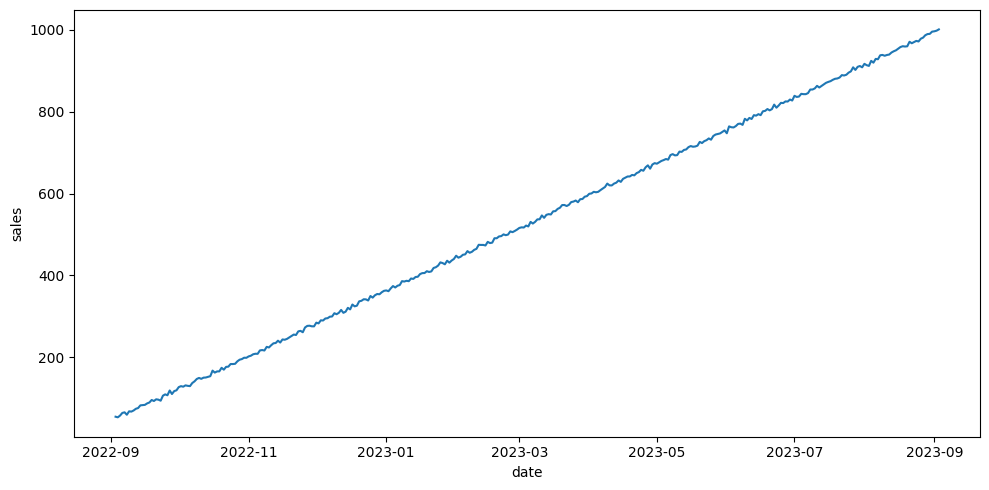

In [146]:
# Visualizamos la serie temporal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)

plt.tight_layout()

plt.show()

 - Tendencia: La tendencia es claramente ascendente, lo que indica un crecimiento constante en las ventas a lo largo del tiempo. Esto podría deberse a un aumento en la demanda de los productos o servicios ofrecidos.

 - Estacionalidad: Dado que no se observa una variación cíclica o estacional clara en los datos, es posible que no haya patrones estacionales significativos en las ventas. Sin embargo, para confirmar esto, sería necesario realizar un análisis más detallado, como descomponer la serie temporal en componentes de tendencia, estacionalidad y residuos.

 - Variabilidad: La variabilidad en la serie parece ser relativamente baja, ya que la línea es casi recta. Esto sugiere una consistencia en las ventas a lo largo del tiempo, con poca fluctuación.

 - Puntos atípicos: No parece haber puntos atípicos o valores extremadamente altos o bajos que se aparten significativamente de la tendencia general de crecimiento. Sin embargo, para confirmar la presencia de puntos atípicos, sería necesario realizar un análisis estadístico más exhaustivo, como identificar valores atípicos basados en criterios específicos.

 - Puntos de inflexión: Dado que la serie muestra una tendencia claramente ascendente sin cambios bruscos en la dirección, es poco probable que haya puntos de inflexión evidentes en los datos. Los puntos de inflexión representan cambios en la dirección de la tendencia, y su ausencia sugiere una evolución gradual y constante en las ventas.

Descomposición de la serie

In [147]:
decomposition = seasonal_decompose(ts, period = 12)
decomposition

# función 'seasonal_decompose' a la serie temporal 'ts' con un período de estacionalidad especificado como '12'.
# La estacionalidad se refiere a patrones que se repiten a lo largo de un período fijo, como los ciclos estacionales mensuales en datos de ventas.
# El parámetro period especifica la longitud del período estacional. En este caso, se asume que hay una estacionalidad de 12 meses (un año).

<statsmodels.tsa.seasonal.DecomposeResult at 0x7f7947b08dc0> es la representación del objeto devuelto por la función seasonal_decompose de statsmodels. Este objeto contiene los resultados de la descomposición estacional, que incluyen la tendencia, la estacionalidad y el residuo. Puedes acceder a estos componentes a través de los atributos del objeto DecomposeResult.

 - Análisis de tendencia

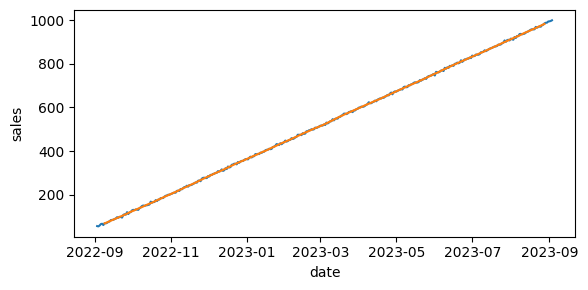

In [148]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (6, 3))

sns.lineplot(data = ts)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

 - Análisis de estacionalidad

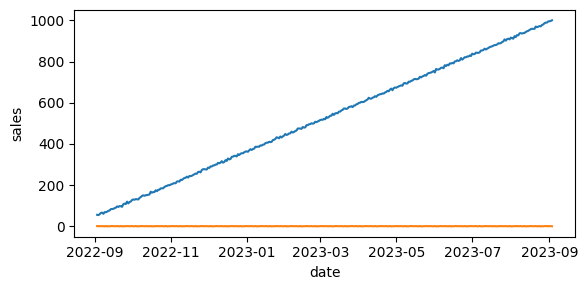

In [149]:
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (6, 3))

sns.lineplot(data = ts)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

Para evaluar la estacionalidad de la serie temporal aplicamos la Prueba de Dickey-Fuller (Dickey-Fuller test), que es un contraste de hipótesis en el que la hipótesis nula es que la serie es estacionaria, y la alternativa, que es no estacionaria.

Si el valor del estadístico de prueba es menor que los valores críticos, podemos rechazar la hipótesis nula de que la serie temporal es no estacionaria.

Si el valor p es menor que un nivel de significancia elegido (por ejemplo, 0.05), también podemos rechazar la hipótesis nula.

In [150]:
# Prueba de Dickey-Fuller

# from statsmodels.tsa.stattools import adfuller - 'adfuller' función se utiliza para realizar la prueba de Dickey-Fuller aumentada (ADF).
                                                 # prueba de hipótesis para verificar la estacionariedad de una serie temporal.

def test_stationarity(timeseries):     # función que toma una serie temporal como entrada
    print("Resultados de la prueba de Dickey-Fuller:")
    
    # Realización de la prueba de Dickey-Fuller:
    dftest = adfuller(timeseries, autolag = "AIC")  # autolag="AIC" especifica que el criterio de información Akaike (AIC) se usará para determinar el número de rezagos en el modelo
    
    # Creación de una Serie Pandas para mostrar los resultados:
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "Lags Used", "Number of Observations Used"])  # Los primeros cuatro elementos de dftest son el estadístico de la prueba, el valor p, el número de rezagos utilizados en la regresión y el número de observaciones utilizadas en la prueba. Estos valores se asignan a la serie dfoutput con etiquetas descriptivas.

    # Inclusión de los valores críticos en la salida:
    for key,value in dftest[4].items():              # Se agregan los valores críticos correspondientes a diferentes niveles de significancia a la serie dfoutput.
        dfoutput["Critical Value (%s)"%key] = value  # Estos valores están almacenados en el quinto elemento de dftest, que es un diccionario
    return dfoutput                                  #  con etiquetas que indican el nivel de significancia y los valores críticos asociados.

test_stationarity(ts)

# dfoutput = pd.Series(dftest[0:4], index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"]): 
#   Crea una serie de pandas (pd.Series) llamada dfoutput que contiene los resultados clave de la prueba de Dickey-Fuller. 

# dftest[0:4] contiene los primeros 4 elementos del resultado de la prueba, que son el estadístico de prueba, el valor p, el número de retrasos utilizados y el número de observaciones utilizadas, respectivamente.
#   Los nombres de los índices se proporcionan como "Test Statistic", "p-value", "#Lags Used" y "Number of Observations Used".

# for key, value in dftest[4].items(): Itera sobre el diccionario devuelto por la prueba de Dickey-Fuller.
#   Este diccionario contiene los valores críticos para diferentes niveles de significancia.

# dfoutput["Critical Value (%s)" % key] = value: Para cada valor crítico, se agrega una nueva entrada a dfoutput 
#    con el nombre del índice como "Critical Value (%s)" % key y el valor correspondiente.

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
Lags Used                       13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

En este caso, el valor p es bastante alto (0.986190), lo que sugiere que no tenemos suficiente evidencia para rechazar la hipótesis nula de no estacionariedad. Además, el estadístico de prueba es mayor que los valores críticos, lo que respalda esta conclusión.

Esta prueba no es necesaria en este caso concret0, ya que la gráfica es muy clara, mostrando el valor de la estacionalidad como una línea recta horizontal en el cero.

 - Análisis de la variabilidad
 
La variabilidad implica el estudio de los residuos: que es cómo fluctúan los datos una vez se ha estudiado la tendencia y la estacionalidad. Para acceder a su información recurrimos a la componente resid de la descomposición.

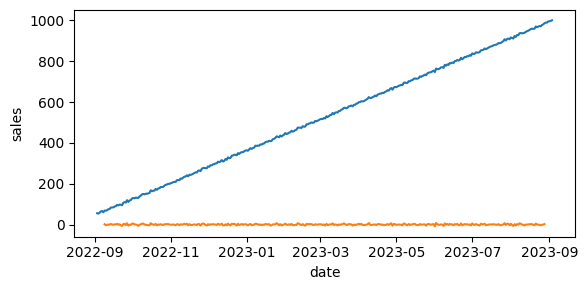

In [151]:
residual = decomposition.resid

fig, axis = plt.subplots(figsize = (6, 3))

sns.lineplot(data = ts)
sns.lineplot(data = residual)

plt.tight_layout()

plt.show()


Variabilidad constante: La línea horizontal en torno al cero indica que, a lo largo de esta tendencia alcista, la variabilidad de los datos se mantiene constante. Aunque los valores de la serie temporal están aumentando con el tiempo, la dispersión o la variabilidad alrededor de esa tendencia no cambia significativamente.

 - Análisis de la autocorrelación

La autocorrelación es la correlación de una serie de tiempo con una copia retrasada de sí misma. Este gráfico nos ayuda a ver si los valores en la serie de tiempo están correlacionados con los valores anteriores.

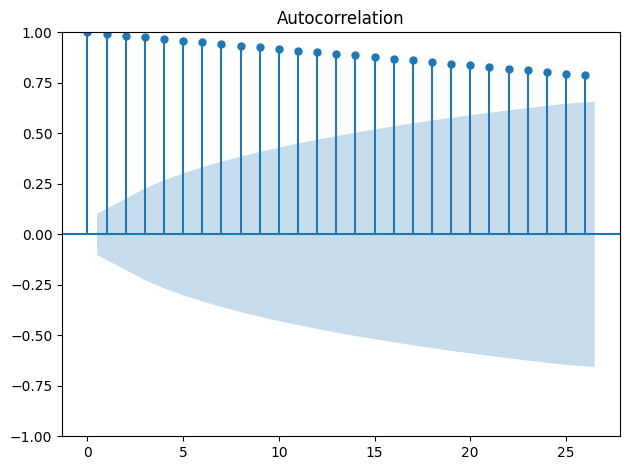

In [152]:
plot_acf(ts)

plt.tight_layout()

plt.show()

Las barras que comienzan en 1 y disminuyen gradualmente hasta 0.75 indican que hay una correlación positiva entre los valores de la serie temporal en el mismo punto en el tiempo y los valores en los retrasos subsiguientes. A medida que aumenta el retraso en el eje X, la autocorrelación disminuye, lo que significa que la correlación entre los valores de la serie en puntos de tiempo separados por más intervalos de tiempo es menor. Esto sugiere cierto grado de dependencia serial en los datos, donde los valores pasados influyen en los valores futuros, pero esta influencia disminuye a medida que pasa el tiempo.

Cada barra te muestra cuánto se parecen las ventas de un día con las de los días posteriores. La altura de la barra te dice cuánto se parecen, y la posición en la cinta métrica te dice cuántos días estás comparando. Si las barras son altas al principio y van bajando gradualmente, significa que las ventas de un día están muy relacionadas con las ventas de los días siguientes, pero esa relación se va debilitando a medida que pasan los días.


 - Modelo ARIMA

In [153]:
model_arima = auto_arima(ts, seasonal = True, trace = True, m = 12)

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1847.125, Time=2.20 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2096.542, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1972.853, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2209.657, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=1844.660, Time=1.09 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1843.274, Time=0.50 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=1845.092, Time=1.34 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=1843.586, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=1841.532, Time=0.43 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=1843.436, Time=1.94 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=1843.433, Time=1.23 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.89 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1839.552, Time=0.33 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=1841.456, Time=0.68 sec
 ARIM

In [154]:
pred = model_arima.predict(50)

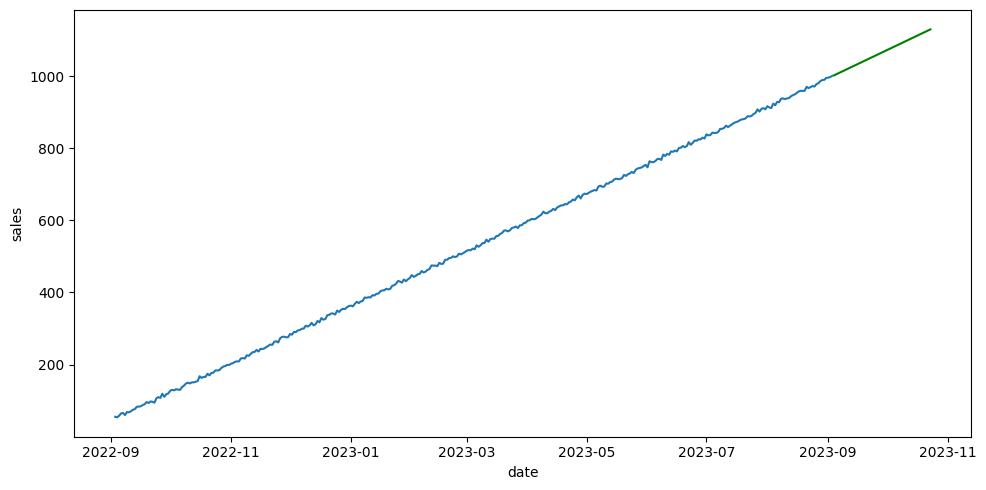

In [155]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = pred, c = "green")

plt.tight_layout()

plt.show()

In [156]:
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  366
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -915.776
Date:                Mon, 15 Apr 2024   AIC                           1839.552
Time:                        11:57:31   BIC                           1855.152
Sample:                    09-03-2022   HQIC                          1845.752
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8110      0.134     21.055      0.000       2.549       3.073
ar.L1         -0.0821      0.052     -1.592      0.111      -0.183       0.019
ma.L1         -0.9413      0.020    -47.701      0.000      -0.980      -0.903
sigma2         8.7903      0.688     12.777      0.000       7.442      10.139
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              1.00   Prob(JB):                         0.68
Heteroskedasticity (H):               0.90   Skew:                             0.07
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Valores AIC y BIC: Son valores bajos, lo que indica un buen ajuste del modelo sin ser demasiado complejo.

Coeficientes significativos: Los coeficientes del modelo con valores p asociados que indican significancia estadística para los coeficientes de intercepto, ar.L1 y ma.L1.

Diagnósticos de residuos: Las pruebas de Ljung-Box (Q) y Jarque-Bera (JB) resulta en un valor alto de p en la prueba Q sugiere que no hay autocorrelación significativa en los residuos. El valor alto de p en la prueba JB sugiere que los residuos se distribuyen normalmente.

Comportamiento visual de los residuos: Aunque no se proporcionan gráficos de los residuos, los resultados de las pruebas sugieren que los residuos se comportan adecuadamente.



In [157]:
# transformamos la serie en estacionaria para optimizar los resultados

ts_stationary = ts.diff().dropna()

test_stationarity(ts_stationary)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
Lags Used                      1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

Test Statistic (Estadístico de Prueba): Este valor es el resultado numérico de la prueba de Dickey-Fuller. En este caso, el valor es aproximadamente -9.43. Cuanto más negativo sea este valor (en términos absolutos), más fuerte es la evidencia en contra de la presencia de raíces unitarias en la serie temporal, lo que sugiere que la serie es estacionaria.

p-value (Valor p): Es la probabilidad de obtener un estadístico de prueba al menos tan extremo como el observado, dado que la hipótesis nula (la serie tiene raíces unitarias, es decir, no es estacionaria) es cierta. Un valor p bajo (generalmente menos de 0.05) sugiere que podemos rechazar la hipótesis nula y concluir que la serie es estacionaria.

Lags Used (Retrasos utilizados): Indica el número de retrasos o rezagos utilizados en la regresión. En este caso, se han utilizado 12 retrasos.

Number of Observations Used (Número de Observaciones Utilizadas): Es el número de observaciones utilizadas en la prueba. Aquí, se han utilizado 352 observaciones.

Critical Values (Valores Críticos): Son los valores de referencia que se comparan con el estadístico de prueba para determinar si la serie es estacionaria o no. Si el valor del estadístico de prueba es menor que estos valores críticos, podemos rechazar la hipótesis nula y concluir que la serie es estacionaria. Los valores críticos están asociados con diferentes niveles de significancia (1%, 5% y 10%). En este caso, el estadístico de prueba es mucho menor que los valores críticos en todos los niveles de significancia, lo que sugiere que la serie es estacionaria.

In [158]:
# el paquete pmdarima y su función auto_arima estiman de forma interna los hiperparámetros más apropiados y genera el mejor modelo posible
model = auto_arima(ts_stationary, seasonal = True, trace = True, m = 12)  

# ts_stationary: La serie temporal que se utilizará para el ajuste del modelo.
# seasonal=True: Indica que el modelo será estacional.
# trace=True: Muestra el progreso de la búsqueda automática.
# m=12: Especifica la frecuencia estacional, en este caso, 12 para datos mensuales.

Performing stepwise search to minimize aic


 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1847.120, Time=2.14 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2096.542, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1972.854, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2209.657, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=1845.127, Time=0.95 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=1843.049, Time=0.42 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=1845.092, Time=1.62 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=1843.587, Time=0.36 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=1841.533, Time=0.48 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=1843.434, Time=1.32 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=1843.433, Time=1.75 sec
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.87 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1839.553, Time=0.41 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=1841.456, Time=0.61 sec
 ARIM

In [159]:
predicciones = model.predict(50)

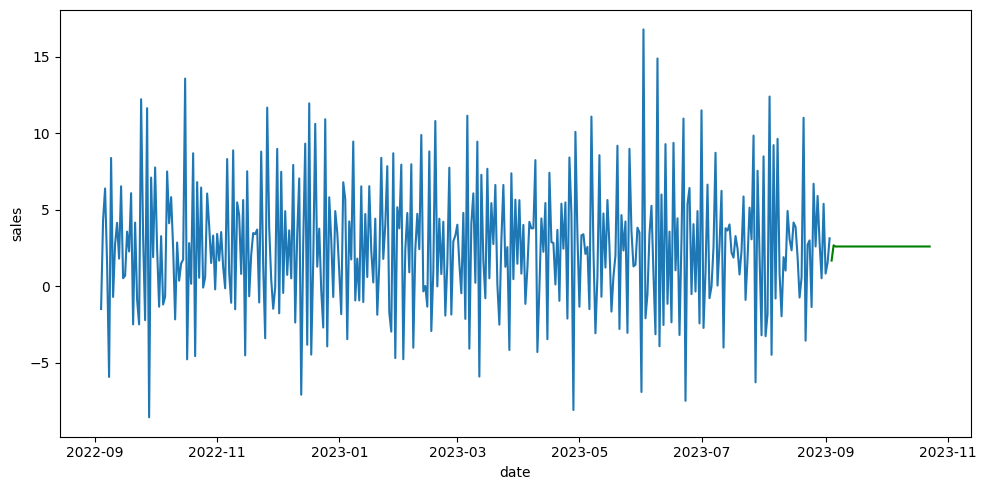

In [160]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_stationary)
sns.lineplot(data = predicciones, c = "green")

plt.tight_layout()

plt.show()

In [161]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -915.776
Date:                Mon, 15 Apr 2024   AIC                           1839.553
Time:                        11:57:48   BIC                           1855.152
Sample:                    09-04-2022   HQIC                          1845.752
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8110      0.134     21.055      0.000       2.549       3.073
ar.L1         -0.0821      0.052     -1.592      0.111      -0.183       0.019
ma.L1         -0.9413      0.020    -47.701      0.000      -0.980      -0.903
sigma2         8.7903      0.688     12.777      0.000       7.442      10.139
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              1.00   Prob(JB):                         0.68
Heteroskedasticity (H):               0.90   Skew:                             0.07
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Los valores AIC y BIC son relativamente bajos (1839.553 y 1855.152 respectivamente), lo que sugiere que el modelo proporciona un buen ajuste a los datos sin ser demasiado complejo. Los coeficientes también parecen ser significativos (los valores p asociados son muy bajos). Además, no hay advertencias en los diagnósticos de los residuos.

Ambos modelos son bastante similares en términos de métricas de ajuste, coeficientes significativos y diagnósticos de residuos. Por lo tanto, en este caso, la elección entre uno u otro puede depender de otros factores, como la interpretación teórica de los parámetros del modelo o la simplicidad del modelo.
Dicho esto, el segundo modelo SARIMAX(1, 0, 1) tiene un AIC ligeramente más bajo (1839.553) en comparación con el primer modelo SARIMAX(1, 1, 1) (1839.552). Aunque la diferencia es mínima, un AIC más bajo generalmente indica un mejor ajuste del modelo. Por lo tanto, basándonos únicamente en este criterio, podríamos decir que el segundo modelo es ligeramente mejor.

- Validación del modelo

In [162]:
ts.head()

date
2022-09-03    55.292157
2022-09-04    53.803211
2022-09-05    58.141693
2022-09-06    64.530899
2022-09-07    66.013633
Name: sales, dtype: float64

/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.21155D+00    |proj g|=  8.61044D-01

At iterate    5    f=  2.98657D+00    |proj g|=  5.36155D-02

At iterate   10    f=  2.91522D+00    |proj g|=  3.20827D-02

At iterate   15    f=  2.88455D+00    |proj g|=  2.69676D-03

At iterate   20    f=  2.87618D+00    |proj g|=  1.50944D-02

At iterate   25    f=  2.87287D+00    |proj g|=  1.76256D-03



At iterate   30    f=  2.87192D+00    |proj g|=  7.72341D-04

At iterate   35    f=  2.87178D+00    |proj g|=  3.79754D-04

At iterate   40    f=  2.87174D+00    |proj g|=  6.01497D-05

At iterate   45    f=  2.87173D+00    |proj g|=  1.44919D-04

At iterate   50    f=  2.87173D+00    |proj g|=  1.70034D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     61      1     0     0   1.700D-04   2.872D+00
  F =   2.8717328375163618     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/vscode/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


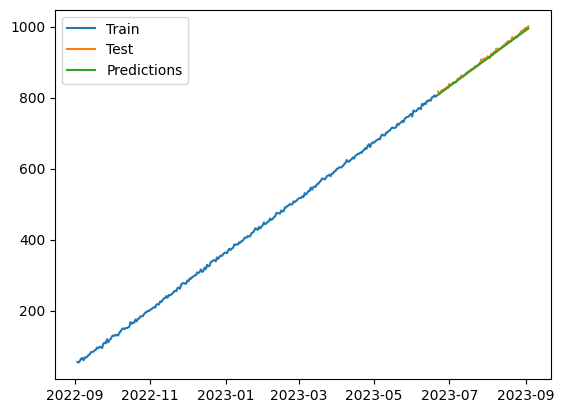

In [163]:
# Validación temporal

train_size = int(len(ts) * 0.8)  # usamos el 80% de los datos para entrenamiento
train, test = ts[0:train_size], ts[train_size:]  # train contiene las primeras train_size (80%) observaciones, test contiene las observaciones restantes después del conjunto de entrenamiento.

# Ajustamos del modelo en el conjunto de entrenamiento
model_val = SARIMAX(train, order=(1, 1, 1))  # Le pasamos el conjunto de entrenamiento (`train`) como los datos y especificamos el orden del modelo SARIMA usando el argumento `order=(1, 0, 1)`. 
# estamos ajustando un modelo SARIMA con un componente autorregresivo de orden 1, un componente de integración de orden 0 y un componente de media móvil de orden 1.
fitted_model = model_val.fit()  # almacenamos el modelo ajustado en una variable

# Evaluamos del modelo en el conjunto de prueba
predictions = fitted_model.forecast(steps=len(test)) # especifica cuántos pasos hacia adelante queremos predecir, en este caso tantos pasos como observaciones hay en el conjunto de prueba.
# forecast(): Este es un método de los modelos SARIMAX ajustados en la biblioteca statsmodels. Este método se utiliza para generar predicciones futuras basadas en el modelo ajustado.
# 

# Comparar predicciones con datos reales
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, predictions, label='Predictions')
plt.legend()
plt.show()

Observamos que las predicciones se ajustan casi perfectamente al conjunto de prueba (test), por lo que en principio estamos ante un buen modelo, con bastante precisión con los valores futuros.

In [164]:
dump(model_arima, open("../models/ARIMA-no-estacionaria.sav", "wb"))
dump(model, open("../models/ARIMA-estacionaria.sav", "wb"))

In [165]:
data_p = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv')
data_p.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [167]:
# Función para el preprocesamiento de datos
def preprocess_data(data_p):
    # Convertir la columna 'date' al formato datetime
    data_p['date'] = pd.to_datetime(data_p['date'])
    data_p['date'] = data_p['date'].dt.date
    data_p = data_p.set_index('date')  # Establecer la columna 'date' como el índice del DataFrame
    data_p = data_p['sales']
    return data_p

# Definir el pipeline
pipeline = Pipeline([
    ('preprocessing', FunctionTransformer(preprocess_data)),
    ('arima', model_arima)
])

# Ajustar el pipeline a los datos
pipeline.fit(data_p)  # Se pasa el DataFrame completo, con la serie temporal 'sales' como la serie temporal 'y'

# Guardar el pipeline
pipeline_file = 'arima_pipeline.pkl'
joblib.dump(pipeline, pipeline_file)

# Cargar el pipeline
loaded_pipeline = joblib.load(pipeline_file)

# Fecha de ejemplo para la predicción
fecha_futura = pd.Timestamp('2023-10-01 12:00:00')

# Realizar la predicción utilizando el pipeline cargado
prediccion_futura = loaded_pipeline.named_steps['arima'].predict(n_periods=1, exogenous=pd.DataFrame(index=[fecha_futura]))
print(f"Predicción para la fecha futura {fecha_futura}: {prediccion_futura.iloc[0]}")

Predicción para la fecha futura 2023-10-01 12:00:00: 1002.1581484702347


/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.21155D+00    |proj g|=  8.61044D-01

At iterate    5    f=  2.98657D+00    |proj g|=  5.36155D-02

At iterate   10    f=  2.91522D+00    |proj g|=  3.20827D-02

At iterate   15    f=  2.88455D+00    |proj g|=  2.69676D-03



At iterate   20    f=  2.87618D+00    |proj g|=  1.50944D-02

At iterate   25    f=  2.87287D+00    |proj g|=  1.76256D-03

At iterate   30    f=  2.87192D+00    |proj g|=  7.72341D-04

At iterate   35    f=  2.87178D+00    |proj g|=  3.79754D-04

At iterate   40    f=  2.87174D+00    |proj g|=  6.01497D-05

At iterate   45    f=  2.87173D+00    |proj g|=  1.44919D-04


/home/vscode/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_650/1793878858.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter([fecha_futura], [prediccion_futura[0]], color='red', label='Future Prediction')  # Agregar la predicción futura como un punto rojo



At iterate   50    f=  2.87173D+00    |proj g|=  1.70034D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     61      1     0     0   1.700D-04   2.872D+00
  F =   2.8717328375163618     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


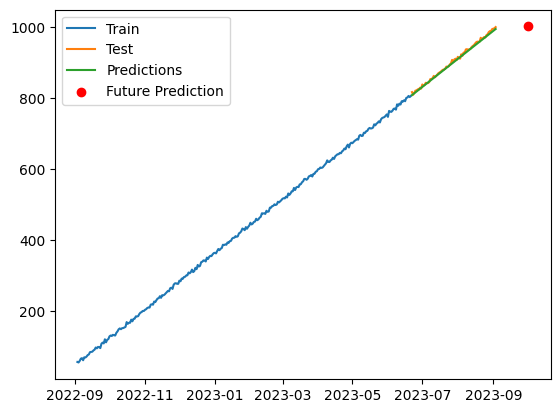

In [170]:
# Validación temporal
ts = preprocess_data(data_p)
train_size = int(len(ts) * 0.8)
train, test = ts[0:train_size], ts[train_size:]
model_val = SARIMAX(train, order=(1, 1, 1))
fitted_model = model_val.fit()
predictions = fitted_model.forecast(steps=len(test))

# Comparar predicciones con datos reales
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, predictions, label='Predictions')
plt.scatter([fecha_futura], [prediccion_futura[0]], color='red', label='Future Prediction')  # Agregar la predicción futura como un punto rojo
plt.legend()
plt.show()

/tmp/ipykernel_650/3745214746.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axis.scatter([fecha_futura], [prediccion_futura[0]], color='red', label='Future Prediction')  # Agregar la predicción futura como un punto rojo


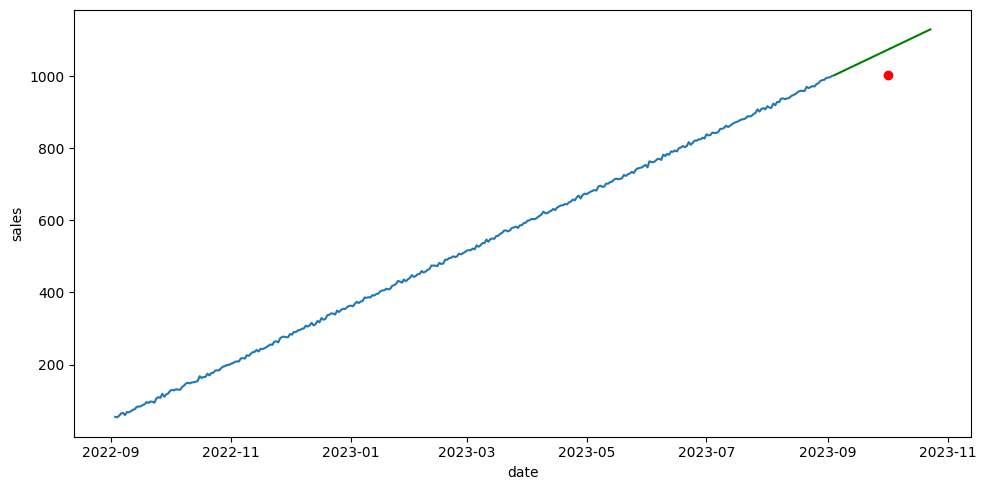

In [169]:
# Graficar la serie temporal y la predicción
fig, axis = plt.subplots(figsize=(10, 5))
sns.lineplot(data=ts, ax=axis)
sns.lineplot(data=pred, color='green', ax=axis)
axis.scatter([fecha_futura], [prediccion_futura[0]], color='red', label='Future Prediction')  # Agregar la predicción futura como un punto rojo
plt.tight_layout()
plt.show()